# Neural Network for XOR function

In [1]:
#import libraries
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [2]:
class neuron:
    
    def __init__(self, value = 0, ActFunctionName = 'sigmoid'):
        self.val = value
        self.ActFunc, self.ActFunc_prime = Activation_function(ActFunctionName).AF() 
        
    def setVal(self, value):
        self.val = value
    
    def getVal(self):
        return self.val
    
    def getActVal(self):
        return self.ActFunc(self.val)
    
    def getActPrimeVal(self):
        return self.ActFunc_prime(self.val)
    

In [3]:
class layer:
    
    def __init__(self, size = 1, ActFunctionName = ' sigmoid'):
        self.neurons = []
        self.size = size
        self.NeuronsVals = np.zeros(size)
        self.NeuronsActVals = np.zeros(size)
        self.NeuronsActPrimeVals = np.zeros(size)

        for i in range(size):
            self.neurons.append(neuron())
    
    
    def setNeuronVal(self, neuron, val):
        self.neurons[neuron - 1].setVal(val)
        self.NeuronsVals[neuron - 1] = val
        self.NeuronsActVals[neuron - 1] = self.neurons[neuron - 1].getActVal()
        self.NeuronsActPrimeVals[neuron - 1] = self.neurons[neuron - 1].getActPrimeVal()

        
    def getNeurons(self):
        return self.size
    
    def getNeuronsVals(self):
        return self.NeuronsVals
        
    def getNeuronsActVals(self):
        return self.NeuronsActVals
    
    def getNeuronsActPrimeVals(self):
        return self.NeuronsActPrimeVals

In [4]:
class Activation_function:
    
    def __init__(self, Function_Name = 'sigmoid'):
        self.functionName = Function_Name
    
    def sigmoid(self, x):
        return 1/(1+np.e**(-x))
    
    def sigmoid_prime(self, x):
        return (1 / (1 + np.e**(- x) ) ) * (1 - 1 / ( 1 + np.e**(-x)) )
        
    def tanh(self, x):
        return np.tanh(x)
        
        
    def tanh_print(self, x):
        return 1-np.tanh(x)**2
        
    def AF(self):
        if self.functionName == 'sigmoid':
            return self.sigmoid, self.sigmoid_prime
        if self.functionName == 'tanh':
            return self.tanh, self.tanh_prime
        
        
        
        
        

In [5]:
class nn:
    
    def __init__(self, topology = [1, 2, 1], eta = 0.1, error = 0, epochs = 10000, max_error = 0.01, ActFunctionName = "sigmoid"):
        self.topology = topology
        self.epochs = epochs
        self.eta = eta
        self.max_error = max_error
        self.layers = []
        self.weights = []
        self.biases = []
        self.error = 0
        self.errorHistory = []
        for size in topology:
            self.layers.append(layer(size,ActFunctionName))
        self.initWeights()
        
    
    def initWeights(self):
        for i in range(1,len(self.topology)):
            self.weights.append(np.random.uniform(-1,1, size=(self.topology[i-1], self.topology[i])))
            self.biases.append(np.random.uniform(-1,1, size = (self.topology[i])))
        


        
        
    def setInputLayer(self, neuronVals):
        for ind, val in enumerate(neuronVals):
            self.layers[0].setNeuronVal(ind + 1, val)
    
    
    def setTarget(self, target):
        self.target = target
        
        
    def Error(self):
        self.errorDerMat = self.target - self.layers[-1].getNeuronsActVals()
        self.error = 0.5*np.sum((self.target - self.layers[-1].getNeuronsActVals())**2)
        
        
    def feedForward(self):
        for layer in range(1, len(self.topology)):
            
            X = self.layers[layer-1].getNeuronsActVals()
            if layer-1 == 0:
                X = self.layers[layer-1].getNeuronsVals()
            W = self.weights[layer-1]
            B = self.biases[layer-1]
            
            Y = X @ W + B

            for neuron in range(self.topology[layer]):
                self.layers[layer].setNeuronVal(neuron + 1, Y[neuron])
        
        self.Error()
    
    def backPropagation(self):
        deltas = []
        derivativesFromOutToHidden = self.layers[-1].getNeuronsActPrimeVals()
        deltasFromOutToHidden = derivativesFromOutToHidden * self.errorDerMat
        deltas.append(deltasFromOutToHidden)
        
        
        
        #for Hidden layer
        count = 0
        
        for layer in reversed(range(1,len(self.topology)-1)):
            
            
            derivativesHidden = self.layers[layer].getNeuronsActPrimeVals()
            deltasHidden = self.weights[layer ]@deltas[count]*derivativesHidden
            deltas.append(deltasHidden)

        
            count = count + 1
        
        count = 0
        for layer in reversed(range(len(self.topology)-1)):

            if layer == 0:
                d = np.tile(deltas[count], (self.topology[layer],1))
                ou = np.transpose(np.tile(self.layers[layer].getNeuronsVals(), (self.topology[layer+1],1)))
                self.weights[layer] = self.weights[layer] + self.eta *d*ou
                
            else:
                d = np.tile(deltas[count], (self.topology[layer],1))
                ou = np.transpose(np.tile(self.layers[layer].getNeuronsActVals(), (self.topology[layer+1],1)))
                self.weights[layer] = self.weights[layer] + self.eta *d*ou
                
            count= count+1
        
        count = 0
        for layer in reversed(range(len(self.topology)-1)):
            self.biases[layer] = self.biases[layer]+ self.eta * deltas[count]
            count = count + 1
            
        
        
    
    def runEpoch(self):
        self.trained = True 
        for ind, inp in enumerate(self.x_train):
            self.setInputLayer(inp)
            self.setTarget(self.y_train[ind])
            self.feedForward()
            if self.error > self.max_error:
                
                self.backPropagation()
                self.trained = False
                
        self.errorHistory.append(self.error)
    
                     
    
    def run(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        for i in tqdm(range(1,self.epochs+1)):
            self.epochTr = i
            self.runEpoch()
            if self.trained == True:
                print(f"The neural net trained after {i} epochs with target MSE {self.max_error:.4f} and η = {self.eta:.2f}")
                return
        
        print(f"Neural Network did not converge after {i} epochs. Current error : {self.error:.4f}")        
        
    def run_check(self, inp, target):
        self.setInputLayer(inp)
        self.setTarget(target)
        self.feedForward()
        print('Checking Input: ', inp)
        print('Target: ', target, 'Output: ', self.layers[-1].getNeuronsActVals(), 'error:', self.error)
        
    
    def MsePlot(self):
        fig = plt.figure(figsize = (13, 9))
        plt.plot(np.linspace(1,self.epochTr,self.epochTr), self.errorHistory, label = '$\eta$ = ' + str(self.eta))
        plt.title("MSE as a function of epochs")
        plt.ylabel('MSE')
        plt.xlabel('Epochs') 
        plt.legend()
        plt.show()
        
    
    def Print(self):
        
        for layer in range(len(self.topology)):
            print(layer,'layer:')
            print('-------------')
            if layer == 0:
                print('Neuron value: \n', self.layers[layer].getNeuronsVals(),'\n')
            else:    
                print('Neuron value: \n', self.layers[layer].getNeuronsActVals())
                print('Weight matrix: \n', self.weights[layer -1])
                print('Bias: \n', self.biases[layer -1], '\n')                         
              
                               
                               

        
        
        
        

In [6]:
#test= nn( topology = [2, 2, 2], eta = 0.5)
#test.setInputLayer([0.05,0.1])
#test.setTarget([0.01,0.99])
#test.feedForward()
#test.Print()
#test.backPropagation()
#print('----------------------------')
#test.Print()

In [7]:
test= nn( topology = [2, 2, 1],epochs = 10000, eta = 0.2)
test.run(x_train = [[0, 0],[1, 0], [0, 1], [1, 1] ], y_train = [[0],[1],[1],[0]])

 25%|█████████▎                           | 2504/10000 [00:02<00:07, 976.03it/s]

The neural net trained after 2505 epochs with target MSE 0.0100 and η = 0.20


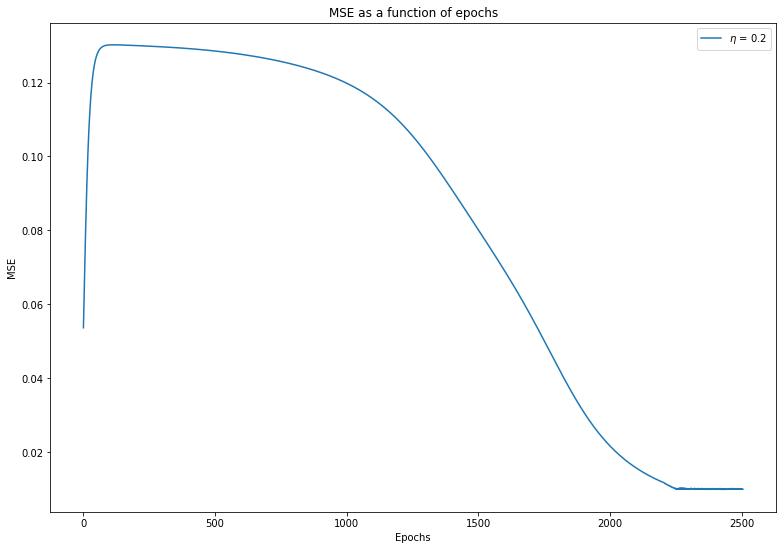

In [8]:
test.MsePlot()

In [9]:
test.run_check([0,0],[0])
test.run_check([0,1],[1])
test.run_check([1,0],[1])
test.run_check([1,1],[0])

Checking Input:  [0, 0]
Target:  [0] Output:  [0.14107818] error: 0.009951525889026737
Checking Input:  [0, 1]
Target:  [1] Output:  [0.85907455] error: 0.009929991904916726
Checking Input:  [1, 0]
Target:  [1] Output:  [0.85920432] error: 0.009911712316872916
Checking Input:  [1, 1]
Target:  [0] Output:  [0.14068998] error: 0.009896834630532172
